# Modeling Growth of a Recently Nucleated Bubble

In this notebook, I predict the nucleation time of a bubble that was observed to grow within the field of view. It had already nucleated, so I will also try to estimate the nucleation time and thus the supersaturation at which nucleation likely occurred. The video is `v360_co2_c5_11184_010_050_0215_63_355_04_19.mp4`.

In [1]:
# adds custom libraries to path
import sys
sys.path.append('src/')
sys.path.append('../libs/')

# import libraries
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize
import scipy.interpolate

# custom libraries
import bubble
import plot.bubble as pltb
import analytics as an
import flow

from importlib import reload
reload(bubble)
reload(an)

# lists data files required
# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = 'input/1k3f_22c.csv'
# load CO2 equation of state data for desired temperature [csv]
eos_co2_file = 'input/eos_co2_22-0C.csv'
# folder to save figures
save_folder = 'figs/'
save_figs = True

### PARAMETRES OF THE EXPERIMENT ###
# viscosity of inner and outer streams [Pa.s]
eta_i = 0.1 # rough estimate of VORANOL 360 + CO2 + C5 dissolved so should be lower
eta_o = 4.815
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
R_nuc = 4E-9  # initial bubble radius, estimated as a bit larger than prediction in slide 13 of 20200305_aps_march_meeting [m]
p_atm = 101.3E3 # atmospheric pressure, assumed to be outlet pressure [Pa]
Q_o = 215/60E9 # outer stream flow rate, input to ISCO 260 D [m^3/s]
Q_i = 50/60E9 # inner stream flow rate, input to ISCO 100 DM [m^3/s]
p_s = 90E5 # saturation pressure of CO2 in VORANOL 360 [Pa]
# distance along channel where bubble was observed [m]
d = 0.063
# frame rate [fps]
fps = 11184 

### PARAMETERS OF THE MODEL
dt = 1E-10 # sets the time step for numerical model [s]
growth_fn = bubble.grow
adaptive_dt = True
if_tension_model = 'ceil'
implicit = False
d_tolman = 5E-9
tol_R = 1E-3
alpha = 0.5
# tolerance on radius of bubble measurement [fractional], estimated by uncertainty in bubble measurement
sigma_R = 0.01

# CONVERSIONS
s_2_ms = 1000
s_2_us = 1E6
kg_2_g = 1E3
kg_2_ng = 1E12
kgm3_2_gmL = 1E-3
m_2_mm = 1000
m_2_um = 1E6
m_2_nm = 1E9
Pa_2_bar = 1E-5
Pa_2_MPa = 1E-6
Nm_2_mNm = 1000

## Compute Properties of Sheath Flow

In [2]:
# computes properties of flow in observation capillary
dp, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i, Q_o, R_o, SI=True)
p_in = p_atm - dp # subtracts dp because it is negative (dp = p_atm - p_in)

## Load Bubble Sizes and Metadata

We will look at the bubble in frames 12898-12921.

In [18]:
# initial and final frames with bubbles (inclusive)
f_i = 9510
f_f = 9527
R_bubble = 8.5E-6 # bubble radius in first frame [m]
x_bubble = d # distance traveled along channel [m]
t_bubble = x_bubble / v # time bubble had traveled down channel [s]

# additional bubbles
f_bubbles = [i for i in range(f_i+1, f_f+1)]
R_bubbles = np.asarray([8.8, 8.8, 9, 9.8, 9.65, 10, 9.65, 10.15, 10.3, 10.3, 10.5, 11.15, 11.25, 
                      11.8, 11.55, 12.15, 12.8])/m_2_um
t_bubbles = np.asarray([t_bubble + (f - f_i)/fps for f in f_bubbles])

### 1) Model Bubble Growth with Epstein-Plesset Model

Our first model will use the Epstein-Plesset model and a fixed diffusivity, selected to match the bubble size data.

#### Predict Nucleation Time

t_nuc = 140.000 ms and error in R is 2.4554.
t_nuc = 160.000 ms and error in R is 1.2657.
t_nuc = 170.000 ms and error in R is 0.9995.
t_nuc = 165.000 ms and error in R is 0.5891.
t_nuc = 167.500 ms and error in R is 0.0236.
t_nuc = 168.750 ms and error in R is 0.4870.
t_nuc = 168.125 ms and error in R is 0.1876.
t_nuc = 167.812 ms and error in R is 0.0754.
t_nuc = 167.656 ms and error in R is 0.0243.
t_nuc = 167.578 ms and error in R is 0.0005.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 167.578 ms


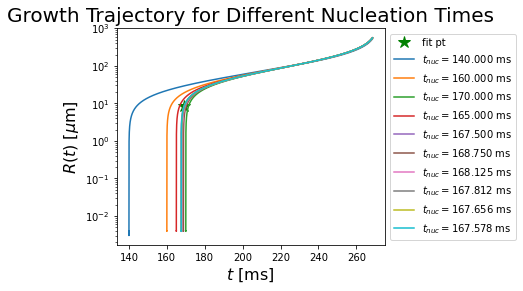

In [25]:
reload(an)
# sets diffusivity to fixed value [m^2/s]
D1 = 2.5E-9 # 5E-9 grew too quickly, 2E-9 too slowly but just by a little
max_iter = 15

# bounds on nucleation time
t_nuc_lo = 0.1 # [s]
t_nuc_hi = 0.18 # [s]

# opens figure to show results of different guesses for bubble nucleation time
fig = plt.figure()
ax = fig.add_subplot(111)

# computes bubble growth trajectory using modified Epstein-Plesset model
args = [dt, p_s, R_nuc, p_atm, L, p_in, v, polyol_data_file, eos_co2_file, adaptive_dt, if_tension_model, 
        implicit, d_tolman, tol_R, alpha, D1]
i_t_nuc = 1

# uses modified shooting method to estimate the nucleation time
t_nuc1, results = an.fit_growth_to_pt(t_bubble, R_bubble, t_nuc_lo, t_nuc_hi, growth_fn, args,
                     i_t_nuc, sigma_R=sigma_R, ax=ax, max_iter=max_iter)

t1, m, D1, p, p_bubble, if_tension, c_s, c_bulk, R, rho_co2 = results
props_list1 = (R, m, p, p_bubble, rho_co2, if_tension)

#### Plot Results

Model prediction at fit point is R = 8.496633 um.


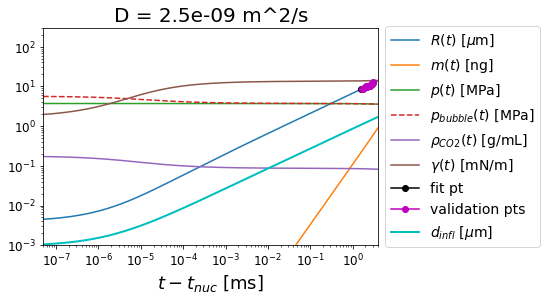

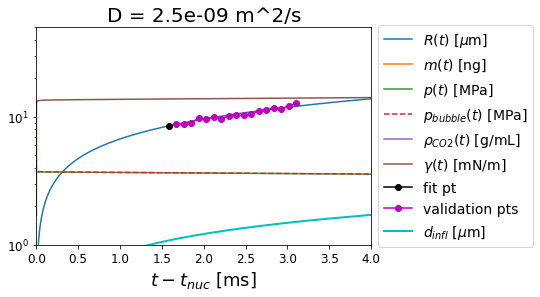

In [27]:
reload(pltb)
# log time axis
x_lim = [0.00000005, 4]
y_lim = [0.001, 300]
x_log = True
title = 'D = {0:.2g} m^2/s'.format(D1)
ax = pltb.all_props(t1, t_nuc1, props_list1, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
ax = pltb.measured(ax, t_nuc1, t_bubble, t_bubbles, R_bubble, R_bubbles, t_R=(t1, props_list1[0]))
ax = pltb.d_infl(ax, t1, t_nuc1, props_list1, c_s[0])
pltb.legend(ax)

# linear time axis
x_lim = [0.0, 4]
y_lim = [1, 50]
x_log = False
ax = pltb.all_props(t1, t_nuc1, props_list1, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
ax = pltb.measured(ax, t_nuc1, t_bubble, t_bubbles, R_bubble, R_bubbles)
ax = pltb.d_infl(ax, t1, t_nuc1, props_list1, c_s[0])

pltb.legend(ax)